# Análise de Crédito Agregado – BACEN/SCR

![Banco Central do Brasil](https://ww2.gestaoni.com.br/painel/storage/031220165128c47532bbb1e2883c902071591ae1ec9b/img_site/g/73f6914fd787c369ac5f8bdda6c72904.jpg)

## Introdução

O Banco Central do Brasil divulga mensalmente um conjunto abrangente de informações agregadas sobre as operações de crédito realizadas no país, com base nos dados do Sistema de Informações de Crédito (SCR).

Este projeto tem como objetivo explorar, analisar e visualizar os dados públicos do SCR, que abrangem:

- Carteira Ativa
- Inadimplência
- Ativos Problemáticos

Os dados estão disponíveis com recortes por tipo de cliente (Pessoa Física ou Jurídica), modalidade de crédito, região geográfica, setor econômico (CNAE), porte/rendimento dos clientes, entre outros. A série histórica cobre o período de **junho de 2012 até os dias atuais**, com atualizações mensais.

**Projeto feito com a base de dados do ano de 2024**

> As informações aqui tratadas são extraídas dos dados abertos publicados pelo Banco Central, podendo haver divergências em relação a outras publicações devido a diferenças nas fontes e metodologias de agregação.

Este notebook realiza uma análise exploratória dos dados agregados do Sistema de Informações de Crédito (SCR),
publicados mensalmente pelo Banco Central do Brasil.

A base utilizada refere-se ao mês de **dezembro de 2024** e contempla informações agregadas de:

- Carteira ativa
- Inadimplência
- Ativos problemáticos

O objetivo é extrair **insights de risco de crédito** que possam subsidiar análises,
políticas de crédito e modelagem estatística.



---



# Importação Bibliotecas


In [51]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

pd.set_option("display.max_columns", None)


# Visualização dos Dados

In [52]:
df = pd.read_csv(
    "../data/planilhas_ano_2024/planilha_202412.csv",
    sep=";"
)

df.head()


,data_base,uf,tcb,sr,cliente,ocupacao,cnae_secao,cnae_subclasse,porte,modalidade,origem,indexador,numero_de_operacoes,a_vencer_ate_90_dias,a_vencer_de_91_ate_360_dias,a_vencer_de_361_ate_1080_dias,a_vencer_de_1081_ate_1800_dias,a_vencer_de_1801_ate_5400_dias,a_vencer_acima_de_5400_dias,vencido_acima_de_15_dias,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico
0,2024-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Cartão de crédito,Sem destinação específica,Prefixado,609,"4225505,49","1245559,17","103358,78","17925,05","11025,00","0,00","186098,00","5789471,49","150711,24","276455,95"
1,2024-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Empréstimo com consignação em folha,Sem destinação específica,Prefixado,615,"1770659,61","4592675,73","10504470,83","7770023,25","7407915,67","0,00","186870,01","32232615,10","1314588,78","1314588,78"
2,2024-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Empréstimo sem consignação em folha,Sem destinação específica,Prefixado,180,"299054,08","933571,60","1375201,99","582934,00","217072,61","0,00","42579,75","3450414,03","234057,31","396215,30"
3,2024-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Habitacional,Com destinação específica,Pós-fixado,<= 15,"55784,28","148552,15","331642,29","216158,63","366119,14","7941,72","0,00","1126198,21","0,00","0,00"
4,2024-12-31,AC,Bancário,S1,PF,PF - Aposentado/pensionista,-,-,PF - Acima de 20 salários mínimos,PF - Outros créditos,Sem destinação específica,Outros indexadores,<= 15,"19331,66","31267,96","66687,68","47589,57","91520,42","3087,88","0,00","259485,17","0,00","0,00"


# Informações dos dados

In [53]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972320 entries, 0 to 972319
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   data_base                       972320 non-null  object
 1   uf                              972320 non-null  object
 2   tcb                             972320 non-null  object
 3   sr                              970196 non-null  object
 4   cliente                         972320 non-null  object
 5   ocupacao                        972320 non-null  object
 6   cnae_secao                      972320 non-null  object
 7   cnae_subclasse                  972320 non-null  object
 8   porte                           972320 non-null  object
 9   modalidade                      972320 non-null  object
 10  origem                          972320 non-null  object
 11  indexador                       972320 non-null  object
 12  numero_de_operacoes           

In [54]:
df.isnull().sum()


data_base                            0
uf                                   0
tcb                                  0
sr                                2124
cliente                              0
ocupacao                             0
cnae_secao                           0
cnae_subclasse                       0
porte                                0
modalidade                           0
origem                               0
indexador                            0
numero_de_operacoes                  0
a_vencer_ate_90_dias                 0
a_vencer_de_91_ate_360_dias          0
a_vencer_de_361_ate_1080_dias        0
a_vencer_de_1081_ate_1800_dias       0
a_vencer_de_1801_ate_5400_dias       0
a_vencer_acima_de_5400_dias          0
vencido_acima_de_15_dias             0
carteira_ativa                       0
carteira_inadimplida_arrastada       0
ativo_problematico                   0
dtype: int64

A base apresenta dados agregados e não contém informações individualizadas.
Valores ausentes são esperados em algumas segmentações (ex.: CNAE para PF).


# Dicionário de Dados – Base SCR (Banco Central)

A base contém dados agregados sobre operações de crédito, divulgados mensalmente pelo Banco Central do Brasil, com segmentações por tipo de cliente, modalidade, região, setor econômico e prazo de vencimento das operações.

| Nome da Coluna                          | Tipo     | Descrição |
|----------------------------------------|----------|-----------|
| `data_base`                             | data     | Data de referência da informação (último dia do mês) |
| `uf`                                    | string   | Unidade da Federação (ex: AC, SP, RJ) |
| `tcb`                                   | string   | Tipo de Conglomerado Bancário (ex: Bancário, Cooperativo, etc.) |
| `sr`                                    | string   | Superintendência Regional ou agrupamento geográfico |
| `cliente`                               | string   | Tipo de cliente: Pessoa Física (PF) ou Jurídica (PJ) |
| `ocupacao`                              | string   | Ocupação do cliente PF (ex: Aposentado/pensionista, Trabalhador formal etc.) |
| `cnae_secao`                            | string   | Seção da CNAE (atividade econômica principal – PJ) |
| `cnae_subclasse`                        | string   | Subclasse da CNAE (atividade econômica mais detalhada – PJ) |
| `porte`                                 | string   | Porte da empresa (PJ) ou faixa de renda (PF) |
| `modalidade`                            | string   | Modalidade da operação de crédito (ex: Cartão de crédito, Consignado etc.) |
| `a_vencer_ate_90_dias`                  | float    | Valor das operações com vencimento em até 90 dias |
| `a_vencer_de_91_ate_360_dias`           | float    | Valor das operações com vencimento entre 91 e 360 dias |
| `a_vencer_de_361_ate_1080_dias`         | float    | Valor das operações com vencimento entre 361 e 1080 dias |
| `a_vencer_de_1081_ate_1800_dias`        | float    | Valor das operações com vencimento entre 1081 e 1800 dias |
| `a_vencer_de_1801_ate_5400_dias`        | float    | Valor das operações com vencimento entre 1801 e 5400 dias |
| `a_vencer_acima_de_5400_dias`           | float    | Valor das operações com vencimento acima de 5400 dias |
| `vencido_acima_de_15_dias`              | float    | Valor total vencido há mais de 15 dias |
| `carteira_ativa`                        | float    | Total da carteira ativa (em dia e vencida) |
| `carteira_inadimplida_arrastada`        | float    | Valor de operações com inadimplência acumulada |
| `ativo_problematico`                    | float    | Soma de inadimplência e reestruturações (ativos problemáticos) |


# Variáveis Categóricas – Segmentação e Perfil de Cliente

| Variável              | Uso em Credit Scoring                                                   |
|-----------------------|-------------------------------------------------------------------------|
| `cliente`             | Segmenta PF ou PJ (modelos separados ou variáveis distintas)            |
| `ocupacao`            | Relevante para PF – Ocupações estáveis tendem a menor inadimplência     |
| `cnae_secao`          | Para PJ – tipo de atividade influencia risco de crédito                 |
| `cnae_subclasse`      | Detalhamento da atividade econômica da PJ                               |
| `porte`               | PJ: porte da empresa; PF: faixa de renda                                |
| `modalidade`          | Cada tipo de produto possui perfil de risco diferente                   |
| `uf`, `sr`            | Risco regional – inadimplência varia por localização                    |

---

# Variáveis Quantitativas – Valores de Crédito e Inadimplência

| Variável                          | Uso em Credit Scoring                                           |
|-----------------------------------|------------------------------------------------------------------|
| `a_vencer_ate_90_dias` até `a_vencer_acima_de_5400_dias` | Perfil de prazo da dívida – risco varia com o tempo de vencimento |
| `vencido_acima_de_15_dias`       | Indica inadimplência em estágio inicial                         |
| `carteira_ativa`                 | Total de operações de crédito registradas                       |
| `carteira_inadimplida_arrastada` | Valor vencido de longo prazo (inadimplência grave)              |
| `ativo_problematico`             | Soma da inadimplência com reestruturações de crédito            |



# Variável Target: `carteira_inadimplida_arrastada`

A variável `carteira_inadimplida_arrastada` representa o valor total das operações de crédito que estão inadimplentes **há mais de 90 dias**. Essas operações são consideradas **créditos de alto risco**, pois os atrasos prolongados indicam forte probabilidade de **calote ou perda financeira** para a instituição financeira.

---

## Importância em Modelagem de Risco de Crédito

Esta variável é amplamente utilizada como **variável target (resposta)** em modelos de **Credit Scoring**, pois:

- Captura inadimplência de forma consolidada (não apenas atraso pontual);
- É adequada para prever o risco de crédito com base em características do cliente e do crédito;
- É compatível com abordagens de classificação e regressão.


# Conversão da variável data_base para o formato time

In [55]:
df["data_base"] = pd.to_datetime(df["data_base"], format="%Y-%m-%d")

# Conversão do tipo das variáveis (object to float)

In [56]:
colunas_numericas = [
    "a_vencer_ate_90_dias",
    "a_vencer_de_91_ate_360_dias",
    "a_vencer_de_361_ate_1080_dias",
    "a_vencer_de_1081_ate_1800_dias",
    "a_vencer_de_1801_ate_5400_dias",
    "a_vencer_acima_de_5400_dias",
    "vencido_acima_de_15_dias",
    "carteira_ativa",
    "carteira_inadimplida_arrastada",
    "ativo_problematico"
]

for col in colunas_numericas:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )


# Classificação binária (inadimplente vs. adimplente)

Podemos criar uma variável auxiliar que identifica se houve inadimplência:

In [57]:
df["inadimplente"] = (
    df["carteira_inadimplida_arrastada"] > 0
).astype(int)

df[["carteira_inadimplida_arrastada", "inadimplente"]].head()


,carteira_inadimplida_arrastada,inadimplente
0,150711.24,1
1,1314588.78,1
2,234057.31,1
3,0.00,0
4,0.00,0


A variável `inadimplente` indica a presença de inadimplência arrastada (> 90 dias),
sendo utilizada posteriormente como variável alvo em modelos de classificação.


# Análise temporal (macro risco sistêmico)

## Evolução da inadimplência ao longo do tempo

In [58]:
df_time = (
    df.groupby("data_base")
    .agg({
        "carteira_ativa": "sum",
        "carteira_inadimplida_arrastada": "sum",
        "ativo_problematico": "sum"
    })
    .reset_index()
)

df_time["tx_inadimplencia"] = (
    df_time["carteira_inadimplida_arrastada"] /
    df_time["carteira_ativa"]
)

df_time


,data_base,carteira_ativa,carteira_inadimplida_arrastada,ativo_problematico,tx_inadimplencia
0,2024-12-31,6.397186e+12,1.953097e+11,4.196578e+11,0.030531


## Gráfico macro (barra – mês único)

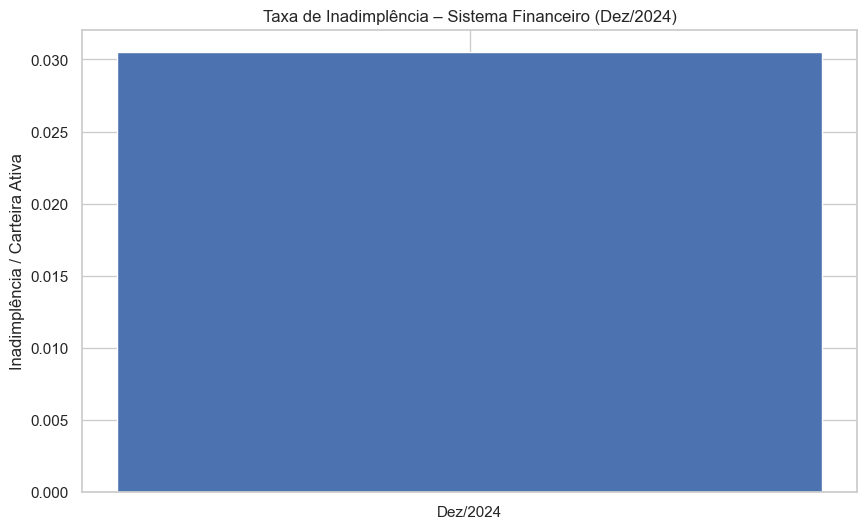

In [59]:
plt.bar(
    ["Dez/2024"],
    df_time["tx_inadimplencia"]
)

plt.title("Taxa de Inadimplência – Sistema Financeiro (Dez/2024)")
plt.ylabel("Inadimplência / Carteira Ativa")
plt.show()


## PF vs PJ

In [60]:
df_cliente = (
    df.groupby("cliente")
    .agg({
        "carteira_ativa": "sum",
        "carteira_inadimplida_arrastada": "sum"
    })
)

df_cliente["tx_inadimplencia"] = (
    df_cliente["carteira_inadimplida_arrastada"] /
    df_cliente["carteira_ativa"]
)

df_cliente


,carteira_ativa,carteira_inadimplida_arrastada,tx_inadimplencia
cliente,,,
PF,3.998270e+12,1.446073e+11,0.036167
PJ,2.398916e+12,5.070233e+10,0.021136


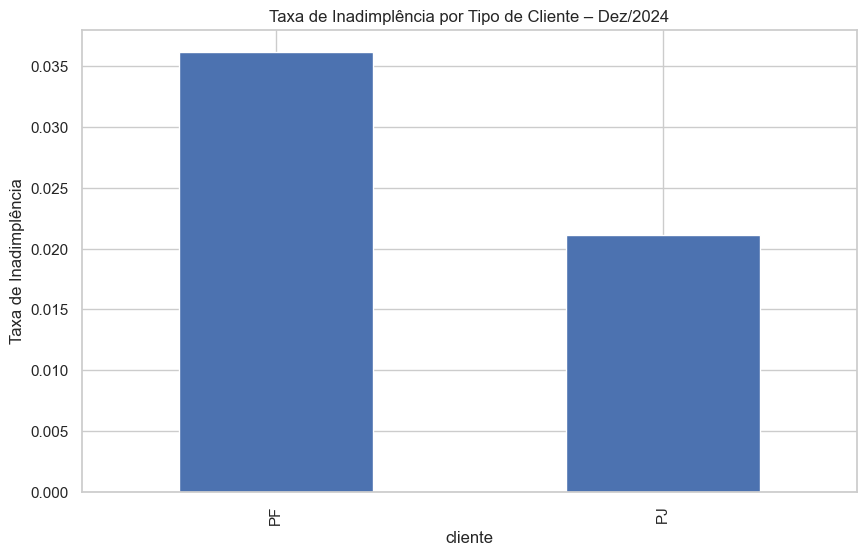

In [61]:
df_cliente["tx_inadimplencia"].plot(
    kind="bar",
    title="Taxa de Inadimplência por Tipo de Cliente – Dez/2024"
)
plt.ylabel("Taxa de Inadimplência")
plt.show()


## Inadimplência por UF (Top 10)

In [62]:
df_uf = (
    df.groupby("uf")
    .agg({
        "carteira_ativa": "sum",
        "carteira_inadimplida_arrastada": "sum"
    })
)

df_uf["tx_inadimplencia"] = (
    df_uf["carteira_inadimplida_arrastada"] /
    df_uf["carteira_ativa"]
)

df_uf.sort_values("tx_inadimplencia", ascending=False).head(10)


,carteira_ativa,carteira_inadimplida_arrastada,tx_inadimplencia
uf,,,
MA,9.742982e+10,4.409153e+09,0.045255
PE,1.447875e+11,6.174513e+09,0.042645
RN,6.107941e+10,2.526496e+09,0.041364
PA,1.357846e+11,5.517233e+09,0.040632
SE,3.879011e+10,1.560256e+09,0.040223
AL,5.027697e+10,1.997981e+09,0.039739
MS,1.282422e+11,4.988135e+09,0.038896
PB,6.385762e+10,2.480110e+09,0.038838
RR,1.310392e+10,5.032604e+08,0.038405


## Modalidade de crédito (produto)

In [63]:
df_modalidade = (
    df.groupby("modalidade")
    .agg({
        "carteira_ativa": "sum",
        "carteira_inadimplida_arrastada": "sum"
    })
)

df_modalidade["tx_inadimplencia"] = (
    df_modalidade["carteira_inadimplida_arrastada"] /
    df_modalidade["carteira_ativa"]
)

df_modalidade.sort_values("tx_inadimplencia", ascending=False)


,carteira_ativa,carteira_inadimplida_arrastada,tx_inadimplencia
modalidade,,,
PF - Outros créditos,2.405862e+11,2.300059e+10,0.095602
PJ - Outros créditos,1.680972e+11,1.355491e+10,0.080637
PF - Cartão de crédito,6.141166e+11,4.181745e+10,0.068094
PF - Empréstimo sem consignação em folha,3.122530e+11,2.066461e+10,0.066179
PJ - Cheque especial e conta garantida,5.693710e+10,2.720597e+09,0.047782
PF - Veículos,3.405350e+11,1.468919e+10,0.043136
PJ - Capital de giro,6.717207e+11,2.474785e+10,0.036842
PF - Empréstimo com consignação em folha,6.753059e+11,1.713392e+10,0.025372
PF - Rural e agroindustrial,6.484890e+11,1.445892e+10,0.022296


## Perfil de prazo da carteira

In [64]:
df["exposicao_longo_prazo"] = (
    df["a_vencer_de_1801_ate_5400_dias"] +
    df["a_vencer_acima_de_5400_dias"]
)

df["pct_longo_prazo"] = (
    df["exposicao_longo_prazo"] /
    df["carteira_ativa"]
).fillna(0)


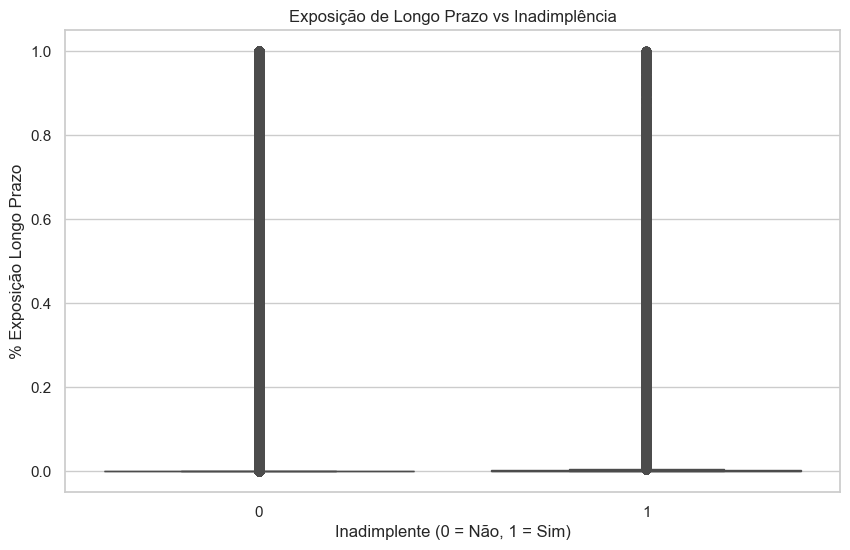

In [65]:
sns.boxplot(
    x="inadimplente",
    y="pct_longo_prazo",
    data=df
)

plt.title("Exposição de Longo Prazo vs Inadimplência")
plt.xlabel("Inadimplente (0 = Não, 1 = Sim)")
plt.ylabel("% Exposição Longo Prazo")
plt.show()


## Correlação entre variáveis financeiras

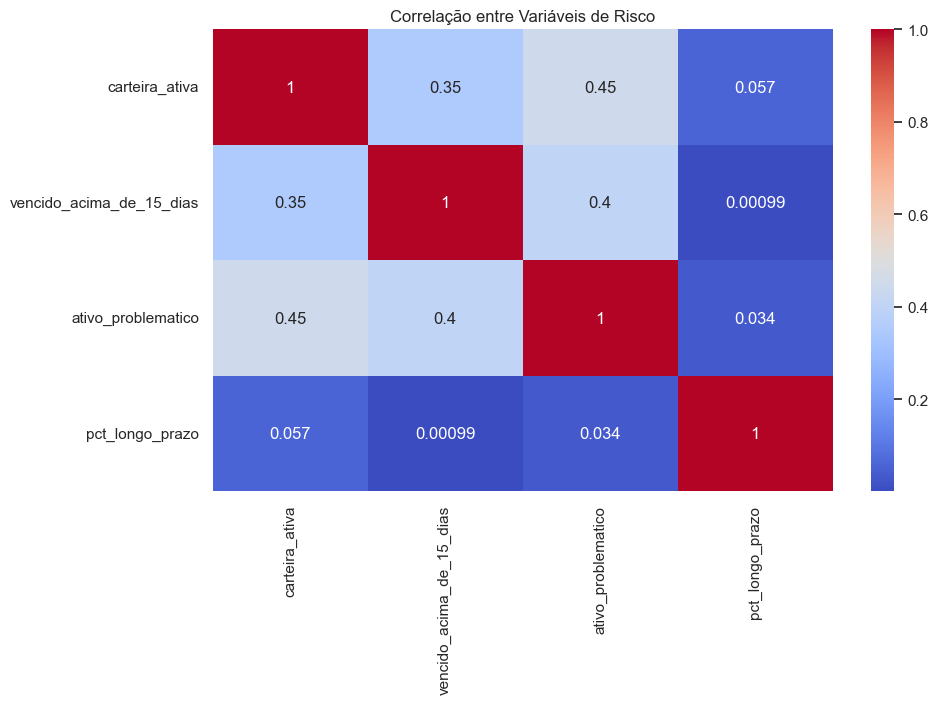

In [66]:
vars_corr = [
    "carteira_ativa",
    "vencido_acima_de_15_dias",
    "ativo_problematico",
    "pct_longo_prazo"
]

sns.heatmap(
    df[vars_corr].corr(),
    annot=True,
    cmap="coolwarm"
)

plt.title("Correlação entre Variáveis de Risco")
plt.show()


# Conclusões Finais

A análise dos dados agregados do SCR referentes a dezembro de 2024 mostrou que o sistema financeiro brasileiro apresenta uma taxa de inadimplência em torno de 3%, o que indica um nível moderado de risco de crédito no período analisado.

Foi possível observar que o risco de inadimplência não é uniforme. Existem diferenças relevantes entre:

- Pessoas Físicas e Pessoas Jurídicas,

- modalidades de crédito,

- regiões do país,

- e perfis de prazo das operações.

Carteiras com maior exposição a prazos longos tendem a apresentar maior risco, o que reforça a importância de considerar a estrutura de vencimento das operações nas análises de crédito. Além disso, os valores de ativos problemáticos mostram que parte do risco já se encontra em estágio mais avançado, indo além de atrasos pontuais.

Mesmo sendo uma base agregada e referente a um único mês, os dados permitem identificar padrões importantes e servem como uma boa base para estudos de risco de crédito, construção de modelos preditivos e apoio à definição de políticas de crédito.

Como próximos passos, a análise pode ser ampliada para uma série histórica maior, permitindo avaliar o comportamento do risco ao longo do tempo e aprofundar a modelagem estatística.